In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install MTCNN

In [19]:
import cv2
import requests
from io import BytesIO
# extract and plot each detected face in a photograph
from matplotlib import pyplot
from matplotlib.patches import Rectangle,Circle
from mtcnn import MTCNN
# from google.colab.patches import cv2_imshow
import zipfile
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder,Normalizer
from sklearn.svm import SVC
from random import choice
from PIL import Image
from numpy import savez_compressed,asarray,load,expand_dims
from keras.models import load_model
from keras_facenet import FaceNet
import tensorflow as tf
from tensorflow.keras import layers, models

In [4]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image

In [5]:
# class Data_Using:

def unzip(zip_dir,out_dir):
    path_folder = out_dir

    zip_file_path = f'{zip_dir}'
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(path_folder)


def load_dataset(directory):
  	# enumerate folders, on per class
  images = []
  path_d = []
  allpath = []
  y = []
  for subdir in os.listdir(directory):

    # print(y)
       	# enumerate files
    for filename in os.listdir(directory+subdir+'/'):
      path = directory + subdir + '/' + filename
          #labels
      y.append(subdir)
      path_d.append(path)
      # print(path_d)
  # allpath.extend(path_d)

  print(path_d)
	  	# store
    # images.append(path_d)
  return path_d , y


def load_data_image(path_image):
    img = cv2.imread(path_image)
    # img = cv2.cvtColor(img,cv2.COLOR)
    return img


def load_data_video(path_video):

    frame_list = []
    # Load the video content using OpenCV
    cap = cv2.VideoCapture(path_video)
    # Loop through the frames and display them
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Display the frame
        # cv2_imshow( frame)

        frame_list.append(frame)

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    # Release the video capture object and close all windows
    cap.release()
    cv2.destroyAllWindows()
    frame_list = np.array(frame_list)
    return frame_list


def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
      ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
      f.write(binary)
    return filename


def load_data_colab_camera():
    try:
      filename = take_photo()
      print('Saved to {}'.format(filename))

      # Show the image which was just taken.
      display(Image(filename))
      # if cv2.waitKey(1) & 0xFF == ord('q'):
      #   cv2.destroyAllWindows()
    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))


def load_data_system_camera():
    # define a video capture object
    vid = cv2.VideoCapture(0)
    while(True):
        # Capture the video frame
        ret, frame = vid.read()
        # Display the resulting frame
        cv2.imshow('frame', frame)
        cv2.imwrite('video.mp4',frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    # After the loop release the cap object
    vid.release()
    # Destroy all the windows
    cv2.destroyAllWindows()



In [6]:
class Face_Detection_Recognition_Video:

    def __init__(self):
      # super.__init__(self)
      self.face_number = 0
      self.folder_number = 0

    def preprocess(self,image):
      #normalize
        pixels = image.astype('float32')
        pixels /= 255.0

        return pixels

      # draw each face separately
    def mtcnn_model(self,filename, result_list):
        # load the image
        # data = pyplot.imread(filename)
        data = filename
        # pyplot.imshow(data)
        # preprocess on image
        # data = self.preprocess(data)
        # get the context for drawing boxes
        ax = pyplot.gca()
        for result in result_list:
          # get coordinates
          x, y, width, height = result['box']
          # create the shape
          rect = Rectangle((x, y), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
          # draw the dots
          for key, value in result['keypoints'].items():
          # create and draw dot
            dot = Circle(value, radius=2, color='red')
            ax.add_patch(dot)
        # pyplot.show()

        # show the plot
        # pyplot.show()
        crop_face = []
        for i in range(len(result_list)):
          # get coordinates
          x1, y1, width, height = result_list[i]['box']
          x2, y2 = x1 + width, y1 + height
          # define subplot
          pyplot.subplot(1, len(result_list), i+1)
          pyplot.axis('off')
          # plot face
          # pyplot.imshow(data[y1:y2, x1:x2])
          Face = data[y1:y2, x1:x2]
          # resize pixels to the model size
          Face = Image.fromarray(Face)
          Face = Face.convert('RGB')
          Face = Face.resize((160,160))
          Face = asarray(Face)#,dtype=np.float32)
          # Face /= 255.0
          crop_face.append(Face)
          # image_face = []
          # for i in crop_face:

          #  image = asarray(image)
          #  image_face.append(Face)
          # face_array = asarray(crop_face)
        # pyplot.show()
        return crop_face


    def get_face(self,path):
        # filename = path
        # pixels = pyplot.imread(filename)
        pixels = path
        pixels = asarray(pixels)
        # create the detector, using default weights
        detector = MTCNN()
        # detect faces in the image
        faces_pos = detector.detect_faces(pixels)
        # display faces
        Faces = self.mtcnn_model(pixels, faces_pos)

        return Faces , faces_pos


    def recognition_MLP(self,):
      pass

    def recognition_CNN(self,):
      pass

    def save_faces(self,data_face):
      folder_name = 'Faces'+f'{self.folder_number}'
      if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
      cv2.imwrite(folder_name + '/' + f'{self.face_number}.jpg',data_face)
      self.face_number += 1

    def face_counting(self,):
      pass

In [ ]:
# path_image = '/content/14605565-c91a-49b0-ba59-39c70413e734.jpeg'
# path_video = '/content/video1.mp4'
# output = 'C:/Users/Zahra.Dabiri/Downloads'
# face_result = Face_Detection_Recognition_Video()
# d = load_data_image(path_image)
# a , b=face_result.get_face(d)
# print(type(a))


# data = load_data_video(path_video)
# import json
# # cam = load_data_colab_camera()
# face_dataset = []
# for i in range(len(d)):
#   faces , pose = face_result.get_face(d[i])
#   face_dataset.append({'face':faces,'position':pose})
# # print(face_dataset)
#   for j in range(len(faces)):
#     face_result.save_faces(faces[j])



In [7]:
path = '/content/drive/MyDrive/Facenet/Photos.zip'
output = '/content/photos'
data = unzip(path,output)

In [8]:
!rm -R /content/photos/__MACOSX

In [9]:
!find . -name "*.DS_Store" -type f -delete

In [ ]:
!pip install keras-facenet

In [ ]:

train_path = '/content/photos/train/'
val_path = '/content/photos/val/'

def faces_dataset(directory):
  X = list()
  newlabels = list()
	# enumerate folders, on per class
  files , labels = load_dataset(directory)
  print(len(files),len(labels))
  for fil,label in zip(files,labels):
    # print(file)
    f = Face_Detection_Recognition_Video()
    img = load_data_image(fil)
    faces , p = f.get_face(img)
    # print(faces[0].shape)
    if not len(faces)== 0:
      X.append(faces)
      newlabels.append(label)
		# summarize progress
    # print('>loaded %d examples for class: %s' % (len(faces), fil))
		# store
    # X.extend(faces)

  return asarray(X), asarray(newlabels)

# load train dataset
trainX, trainy = faces_dataset(train_path)
# load test dataset
testX, testy = faces_dataset(val_path)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

In [ ]:
# calculate a face embedding for each face in the dataset using facenet

def get_embedding(face_img):

    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = asarray(face_img)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

embedder = FaceNet()

# load the face dataset
# data = load('5-celebrity-faces-dataset.npz',allow_pickle=True)

# trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX[0][0].shape, testy.shape)

# convert each face in the train set to an embedding
newTrainX , newTrainy = list(),list()
for face_pixels,label in zip(trainX,trainy):
  try:
    embedding = get_embedding(face_pixels[0])
    newTrainX.append(embedding)
    newTrainy.append(label)
  except:
    print(label)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX ,newTesty = list(),list()
for face_pixels,label in zip(testX,testy):
  try:
    embedding = get_embedding(face_pixels[0])
    newTestX.append(embedding)
    newTesty.append(label)
  except:
    print(label)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
# savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, newTrainy, newTestX, newTesty)


In [18]:
# Prepare data for Cnn

Cnn_trainx = []
for p in trainX:
  Cnn_trainx.append(p[0])
Cnn_trainx = np.array(Cnn_trainx)
print(Cnn_trainx.shape)

Cnn_testx = []
for p in testX:
  Cnn_testx.append(p[0])
Cnn_testx = np.array(Cnn_testx)
print(Cnn_testx.shape)

train_y, test_y = newTrainy , newTesty
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(train_y)
train_y = out_encoder.transform(train_y)
test_y = out_encoder.transform(test_y)
# print(test_y)
# print(testy)
# del selection,random_face_pixels,random_face_emb,random_face_class,random_face_name
# test model on a random example from the test dataset
selection = choice([i for i in range(Cnn_testx.shape[0])])
random_face_pixels = Cnn_testx[selection]
random_face_emb = Cnn_testx[selection]
random_face_class = test_y[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])


(91, 160, 160, 3)
(24, 160, 160, 3)


In [20]:
# Classifier with CNN

model_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(256, activation='relu'),
    layers.Dense(5, activation='softmax')  # num_classes is the number of identities
])
model_cnn.summary()
# Compile the model
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model (assuming you have X_train and y_train as your training data)
model_cnn.fit(Cnn_trainx, train_y, epochs=40)# ,validation_data=(testX, test_y))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2832 (Conv2D)        (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d_1416 (MaxPoo  (None, 79, 79, 32)        0         
 ling2D)                                                         
                                                                 
 conv2d_2833 (Conv2D)        (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1417 (MaxPoo  (None, 38, 38, 64)        0         
 ling2D)                                                         
                                                                 
 conv2d_2834 (Conv2D)        (None, 36, 36, 128)       73856     
                                                                 
 max_pooling2d_1418 (MaxPoo  (None, 18, 18, 128)       0

In [23]:
# Evaluate the model on the test set
test_loss, test_acc = model_cnn.evaluate(Cnn_testx, test_y)
print(f'Test accuracy: {test_acc}')

1/1 [==============================] - 0s 246ms/step - loss: 4.9960 - accuracy: 0.5833
Test accuracy: 0.5833333134651184


1/1 [==============================] - 0s 88ms/step
[[1.3606957e-05 3.3928975e-06 9.9998283e-01 1.1566690e-07 8.0049006e-10]]
Predicted: ['jerry_seinfeld']
Expected: jerry_seinfeld
Predicted class: [2], Confidence: 100.00%


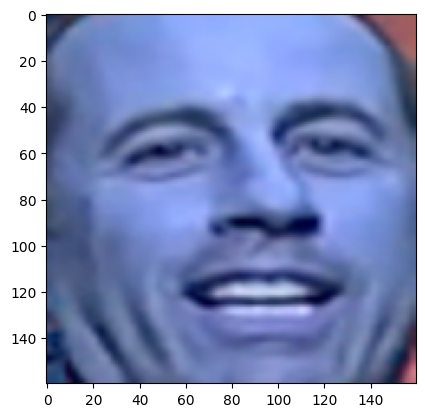

In [24]:
# in_encoder = Normalizer(norm='l2')
# test_X = in_encoder.transform(test_X)
# print(train_X.shape)
# label encode targets


# print(random_face_pixels.shape)
random_face = np.array(random_face_pixels)
random_face = random_face.reshape(1,160,160,3)
# print(random_face.shape)
pred = model_cnn.predict(random_face)
print(pred)
random_face_name = out_encoder.inverse_transform([random_face_class])
# print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
# print('random_face_class',pred[0][random_face_class])

class_index = tf.argmax(pred, axis=1)
confidence = tf.reduce_max(pred[0][random_face_class])
pred_name = out_encoder.inverse_transform(class_index)
print('Predicted: %s' % pred_name)
print('Expected: %s' % random_face_name[0])
# Assuming you have a list of class labels
# class_label = test_y[class_index.numpy()[0]]

print(f"Predicted class: {class_index}, Confidence: {confidence * 100:.2f}%")

# plot for fun
# print(random_face_pixels.shape)
pyplot.imshow(random_face_pixels)
# title = '%s (%.3f)' % (random_face_name, pred_name)
# pyplot.title(title)
pyplot.show()

In [25]:
# Prepare data for LBPH

LBPH_trainx = []
for p in trainX:
  # p[0] = cv2.cvtColor(p[0], cv2.COLOR_GRAY2BGR)
  p[0] = cv2.cvtColor(p[0], cv2.COLOR_BGR2GRAY)
  # n = p[0].shape + (1,)
  # p[0] = np.reshape(p[0],n)
  LBPH_trainx.append(p[0])
LBPH_trainx = np.array(LBPH_trainx)
print(LBPH_trainx.shape)
# print(New_trainx[1])
# float32_array = trainX.astype(tf.float32)
# train_y = np.array([np.array(group) for group in train_y])
LBPH_testx = []
for p in testX:
  p[0] = cv2.cvtColor(p[0], cv2.COLOR_BGR2GRAY)
  # n = p[0].shape + (1,)
  # p[0] = np.reshape(p[0],n)
  LBPH_testx.append(p[0])
LBPH_testx = np.array(LBPH_testx)
# trainX = tf.convert_to_tensor(trainX)
# train_y = tf.cast(train_y , dtype=tf.float32)
# trainX = np.asarray(trainX)
# print(trainX.shape)
# trainX = np.reshape(trainX,[160,160,3])
# print(type(train_y),train_y.shape)

(91, 160, 160)


In [ ]:
# Classifier with LBPH

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , accuracy_score
# from pyimagesearch.faces import load_face_dataset
import argparse
import imutils
import time

In [ ]:
# train our LBP face recognizer
# print("[INFO] training face recognizer...")
recognizer = cv2.face.LBPHFaceRecognizer_create(
	radius=2 , neighbors=16, grid_x=8, grid_y=8)
start = time.time()
recognizer.train(LBPH_trainx, train_y)
end = time.time()
print("[INFO] training took {:.4f} seconds".format(end - start))

[INFO] training took 2.0551 seconds


In [ ]:
# initialize the list of predictions and confidence scores
# print("[INFO] gathering predictions...")
predictions = []
confidence = []
start = time.time()
# loop over the test data
for i in range(0, len(LBPH_testx)):
	# classify the face and update the list of predictions and
	# confidence scores
  # print(LBPH_testx[i].shape)
  (prediction, conf) = recognizer.predict(LBPH_testx[i])
  predictions.append(prediction)
  confidence.append(conf)
# measure how long making predictions took
end = time.time()
print("[INFO] inference took {:.4f} seconds".format(end - start))
# show the classification report
# le = LabelEncoder()
print(classification_report(test_y, predictions))#,target_names=le.classes_))
predictions = np.array(predictions)

print('test_y:',test_y)
print('predictions:',predictions)
print('accuracy :',accuracy_score(test_y,predictions))

[INFO] inference took 26.1824 seconds
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.75      0.86         4
           2       0.71      1.00      0.83         5
           3       1.00      0.40      0.57         5
           4       0.83      1.00      0.91         5

    accuracy                           0.83        24
   macro avg       0.88      0.83      0.82        24
weighted avg       0.87      0.83      0.81        24

test_y: [1 1 1 1 0 0 0 0 0 2 2 2 2 2 4 4 4 4 4 3 3 3 3 3]
predictions: [1 1 1 2 0 0 0 0 0 2 2 2 2 2 4 4 4 4 4 4 3 3 2 0]
accuracy : 0.8333333333333334


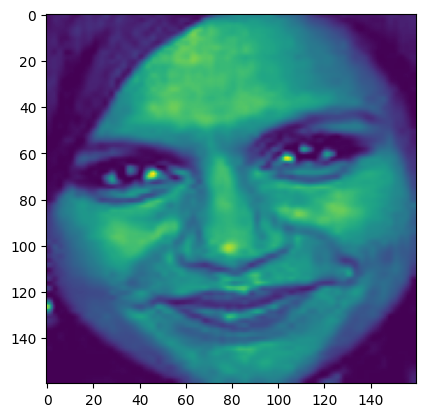

(160, 160)
Predicted: ['mindy_kaling']
Expected: mindy_kaling
class_number_pred: 4 - confidence: 107.33005308513054


In [ ]:
from skimage.color import rgb2gray
random_face = np.array(random_face_pixels)
# random_face = rgb2gray(random_face)/255
# Convert a BGR image to grayscale
random_face = cv2.cvtColor(random_face, cv2.COLOR_BGR2GRAY)
pyplot.imshow(random_face)
pyplot.show()
print(random_face.shape)

(prediction, conf) = recognizer.predict(random_face)

random_face_name = out_encoder.inverse_transform([random_face_class])
pred_name = out_encoder.inverse_transform([prediction])

print('Predicted: %s' % pred_name)
print('Expected: %s' % random_face_name[0])
print('class_number_pred:',prediction, '-' , 'confidence:',conf)

(91, 512)
(91,)
[1 1 1 1 0 0 0 0 0 2 2 2 2 2 4 4 4 4 4 3 3 3 3 3]
[1 1 1 1 0 0 0 0 0 2 2 2 2 2 4 4 4 4 4 3 3 3 3 3]
accuracy : 1.0
Predicted: elton_john (94.285)
Expected: elton_john
(160, 160)


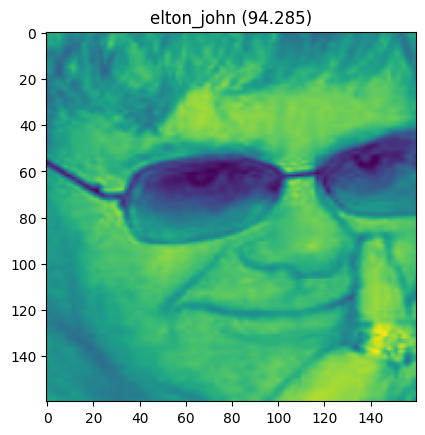

In [ ]:
# Classifier with SVM

# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
# data = load('5-celebrity-faces-dataset.npz',allow_pickle=True)
testX_faces = testX
# load face embeddings
# data = load('5-celebrity-faces-embeddings.npz')
train_X, train_y, test_X, test_y = newTrainX, newTrainy, newTestX, newTesty
# normalize input vectors
in_encoder = Normalizer(norm='l2')
train_X = in_encoder.transform(train_X)
test_X = in_encoder.transform(test_X)
print(train_X.shape)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(train_y)
train_y = out_encoder.transform(train_y)
test_y = out_encoder.transform(test_y)
print(train_y.shape)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(train_X, train_y)
# test model on a random example from the test dataset
selection = choice([i for i in range(test_X.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = test_X[selection]
# print(random_face_emb.shape)
random_face_class = test_y[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

# accuracy
# predict = []
# for i in range(0, len(test_X)):
#   # a = expand_dims(test_X, axis=0)
#   test_X[i].reshape(-1,1)
#   print(test_X[i].shape)
predict = model.predict(test_X)
print(predict)
print(test_y)
print('accuracy :',accuracy_score(test_y,predict))

# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
print(random_face_pixels[0].shape)
pyplot.imshow(random_face_pixels[0])
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()